In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
softThreshold(u,μ) = (sign.(u) .* max.(abs.(u) .- μ, 0))
normalizeU(u) = u.*sign.(sum(u))/maximum(u*sign.(sum(u)))
normalizeU(u,v) = u.*sign.(sum(v))/maximum(v*sign.(sum(v)))
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);

In [3]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

In [4]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq, LinearAlgebra
using Plots

In [5]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [6]:
# Parameters
grid_resolution        = 200
quadrature_order       = 5
ϵ                      = 3                # perturbation
nev                    = 10
t_initial              = minimum(Time)
t_end                  = t_initial+60     # parameter value corresponding to ϵ=0
scale                  = 1
solver_tolerance       = 1e-10
solver                 = OrdinaryDiffEq.BS5();

In [7]:
T(x, param) = flow(interp_rhs, x, [t_initial, t_end + scale*param], p=UV,
        tolerance=solver_tolerance,solver=solver)[end]

T (generic function with 1 method)

In [8]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [9]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [10]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

156.888128 seconds (91.93 M allocations: 5.215 GiB, 0.77% gc time)


In [11]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata);

In [12]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

1810.154675 seconds (111.39 M allocations: 8.932 GiB, 0.08% gc time)


In [13]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

  3.490453 seconds (9.21 M allocations: 612.585 MiB, 3.23% gc time)


In [47]:
# calculate the exact uϵ
λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

In [15]:
# solve the system for the derivative u_dot
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    @time u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

  2.103994 seconds (4.18 M allocations: 418.902 MiB, 17.43% gc time)
  0.502167 seconds (65.92 k allocations: 219.493 MiB, 1.73% gc time)
  0.482455 seconds (298 allocations: 232.431 MiB, 1.34% gc time)
  0.509789 seconds (298 allocations: 215.857 MiB, 1.68% gc time)
  0.490527 seconds (298 allocations: 215.857 MiB, 0.99% gc time)
  0.493689 seconds (298 allocations: 215.857 MiB, 0.65% gc time)
  0.483965 seconds (298 allocations: 215.857 MiB, 0.68% gc time)
  0.486474 seconds (298 allocations: 215.857 MiB, 0.86% gc time)
  0.490964 seconds (298 allocations: 215.857 MiB, 0.64% gc time)
  0.492829 seconds (298 allocations: 215.857 MiB, 0.70% gc time)


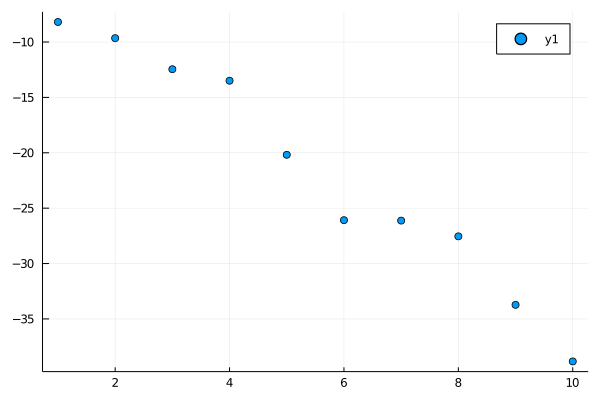

In [16]:
#select number of evs
Plots.scatter(1:nev,λ₀)

In [48]:
# gap after 4
nev = 4
u₀ = u₀[:,1:nev]
λ₀ = λ₀[1:nev]
uϵ = uϵ[:,1:nev]
λϵ = λϵ[1:nev]
u_dot = u_dot[:,1:nev]
λ_dot = λ_dot[1:nev];

In [51]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmins =     [-2, -2, -2, -2]
cmaxs =     -1 .* cmins
cmins_lr =  [-0.1, -0.1, -0.1, -0.1]
cmaxs_lr =  -1 .* cmins_lr;

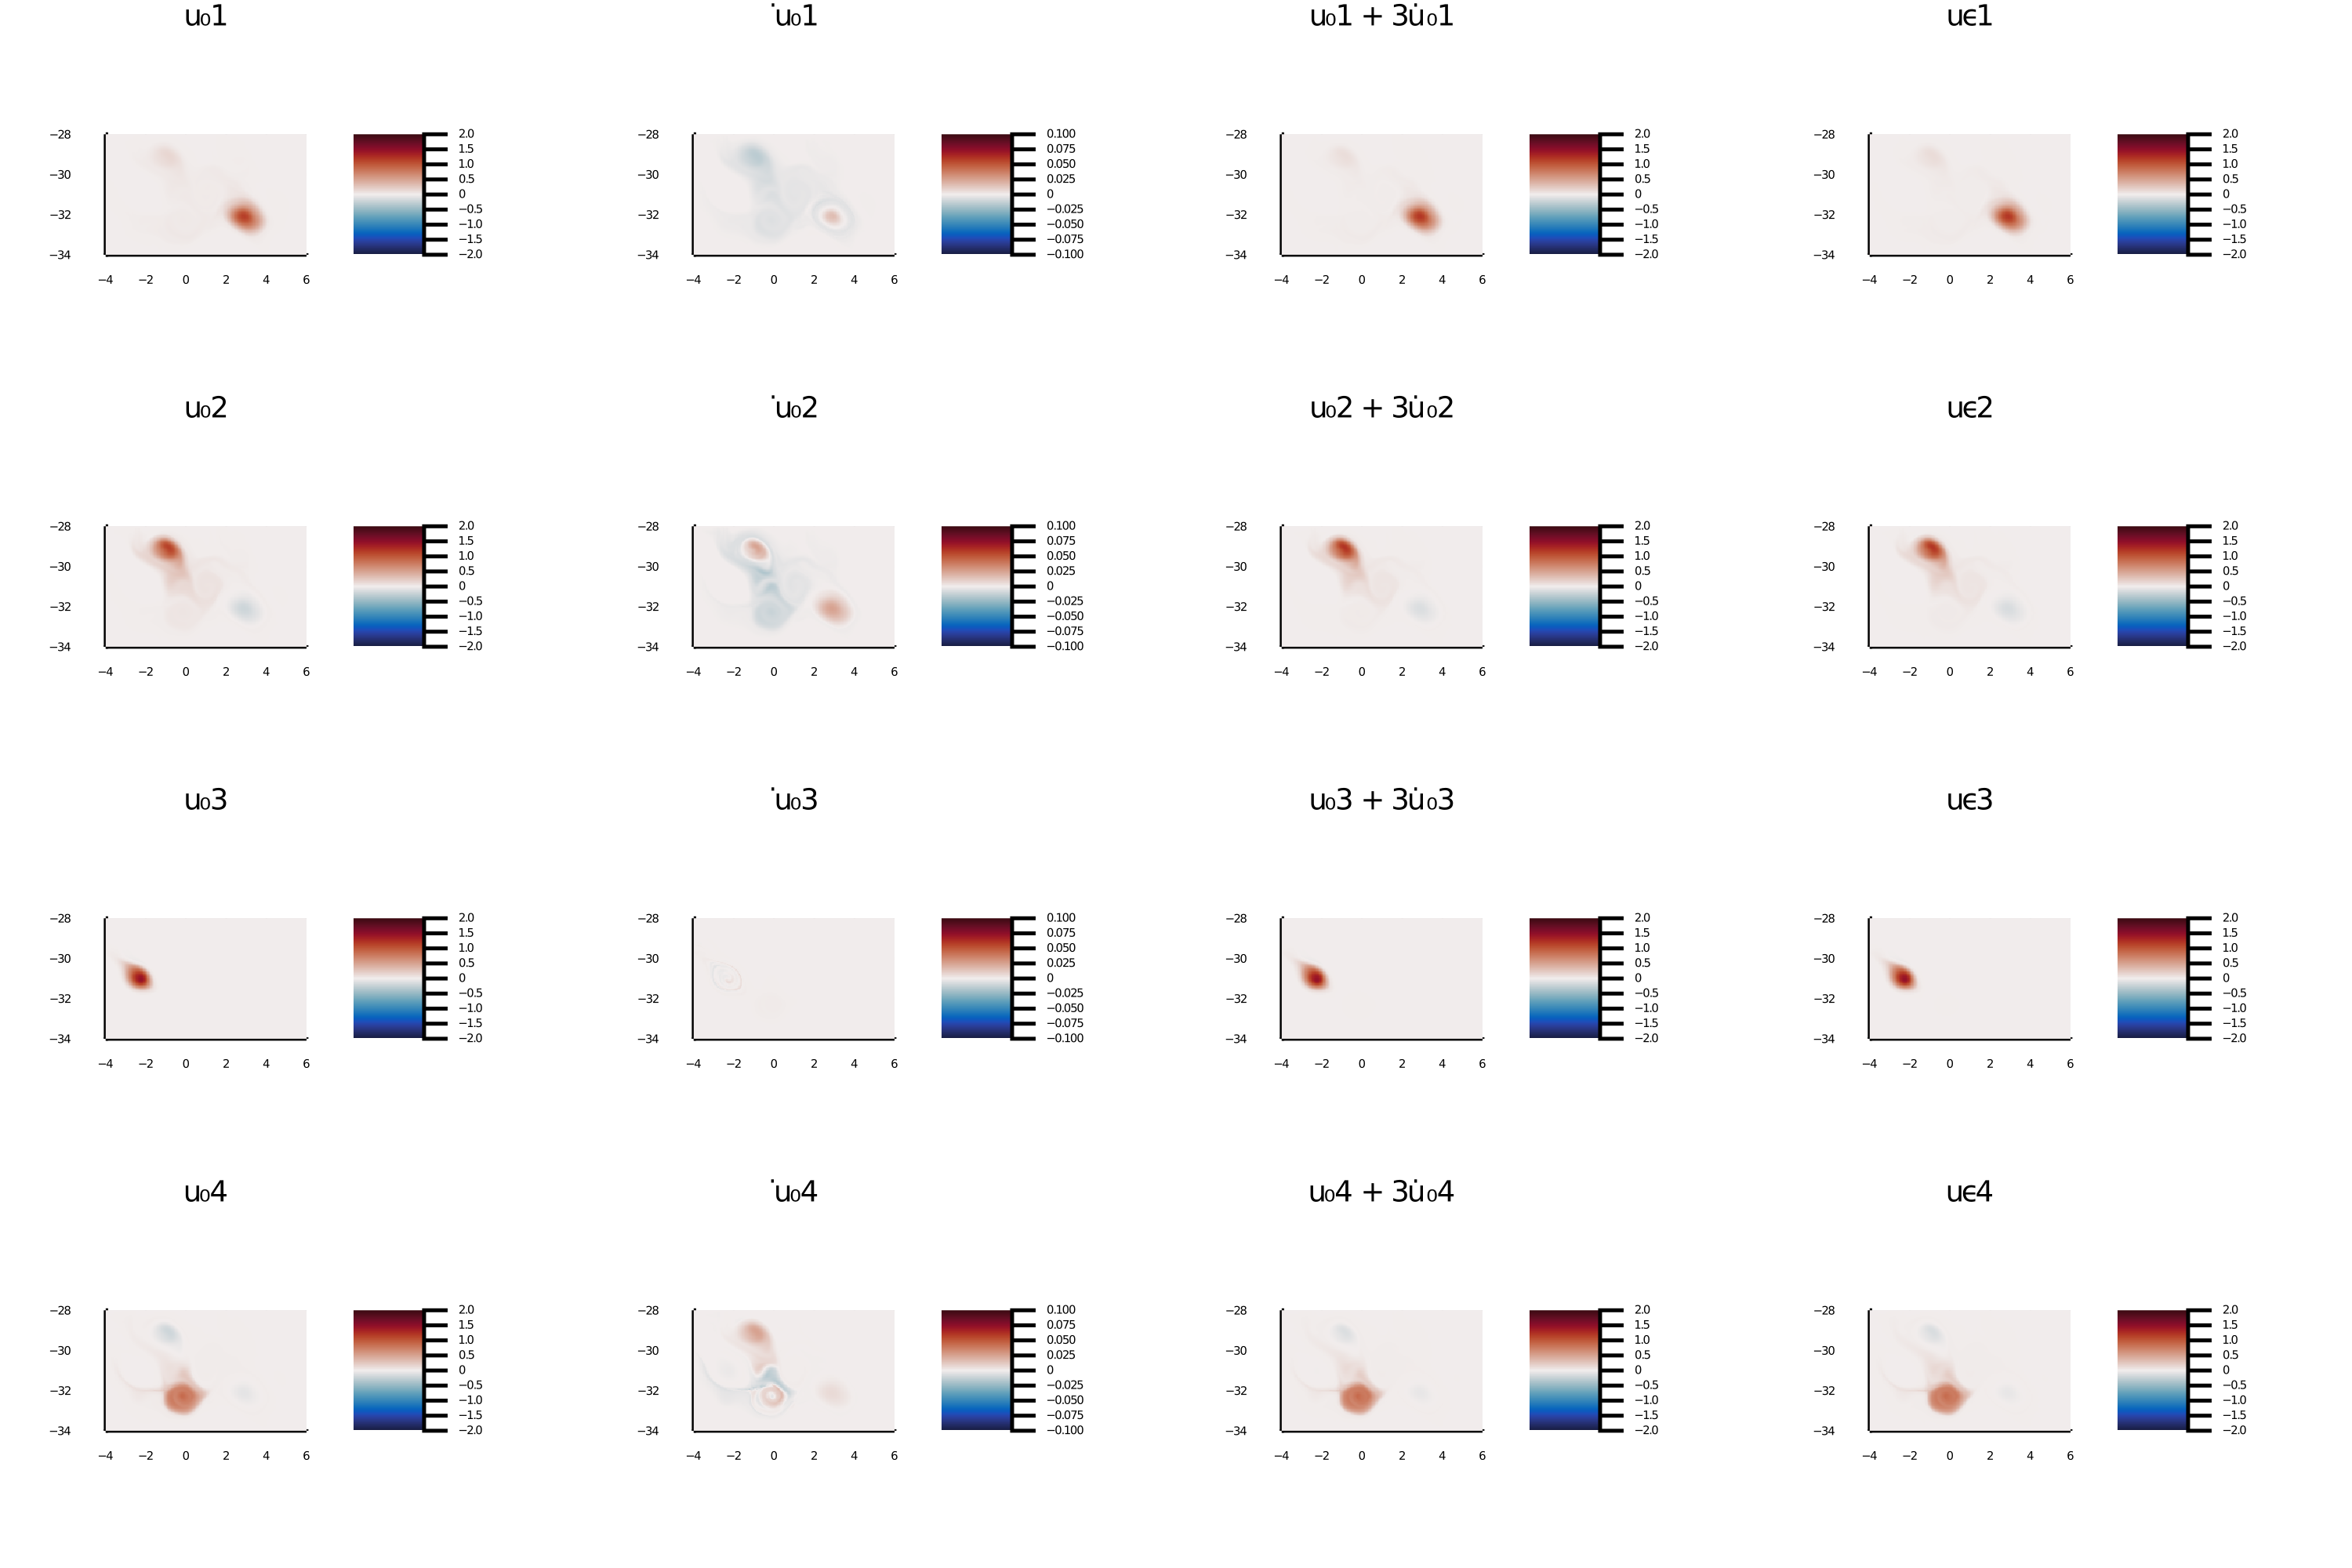

In [52]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i], lon_resolution, lat_resolution, bdata=bdata,
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [46]:
# reorder where neccessary
#uϵ = uϵ[:,[1,2,4,3]];

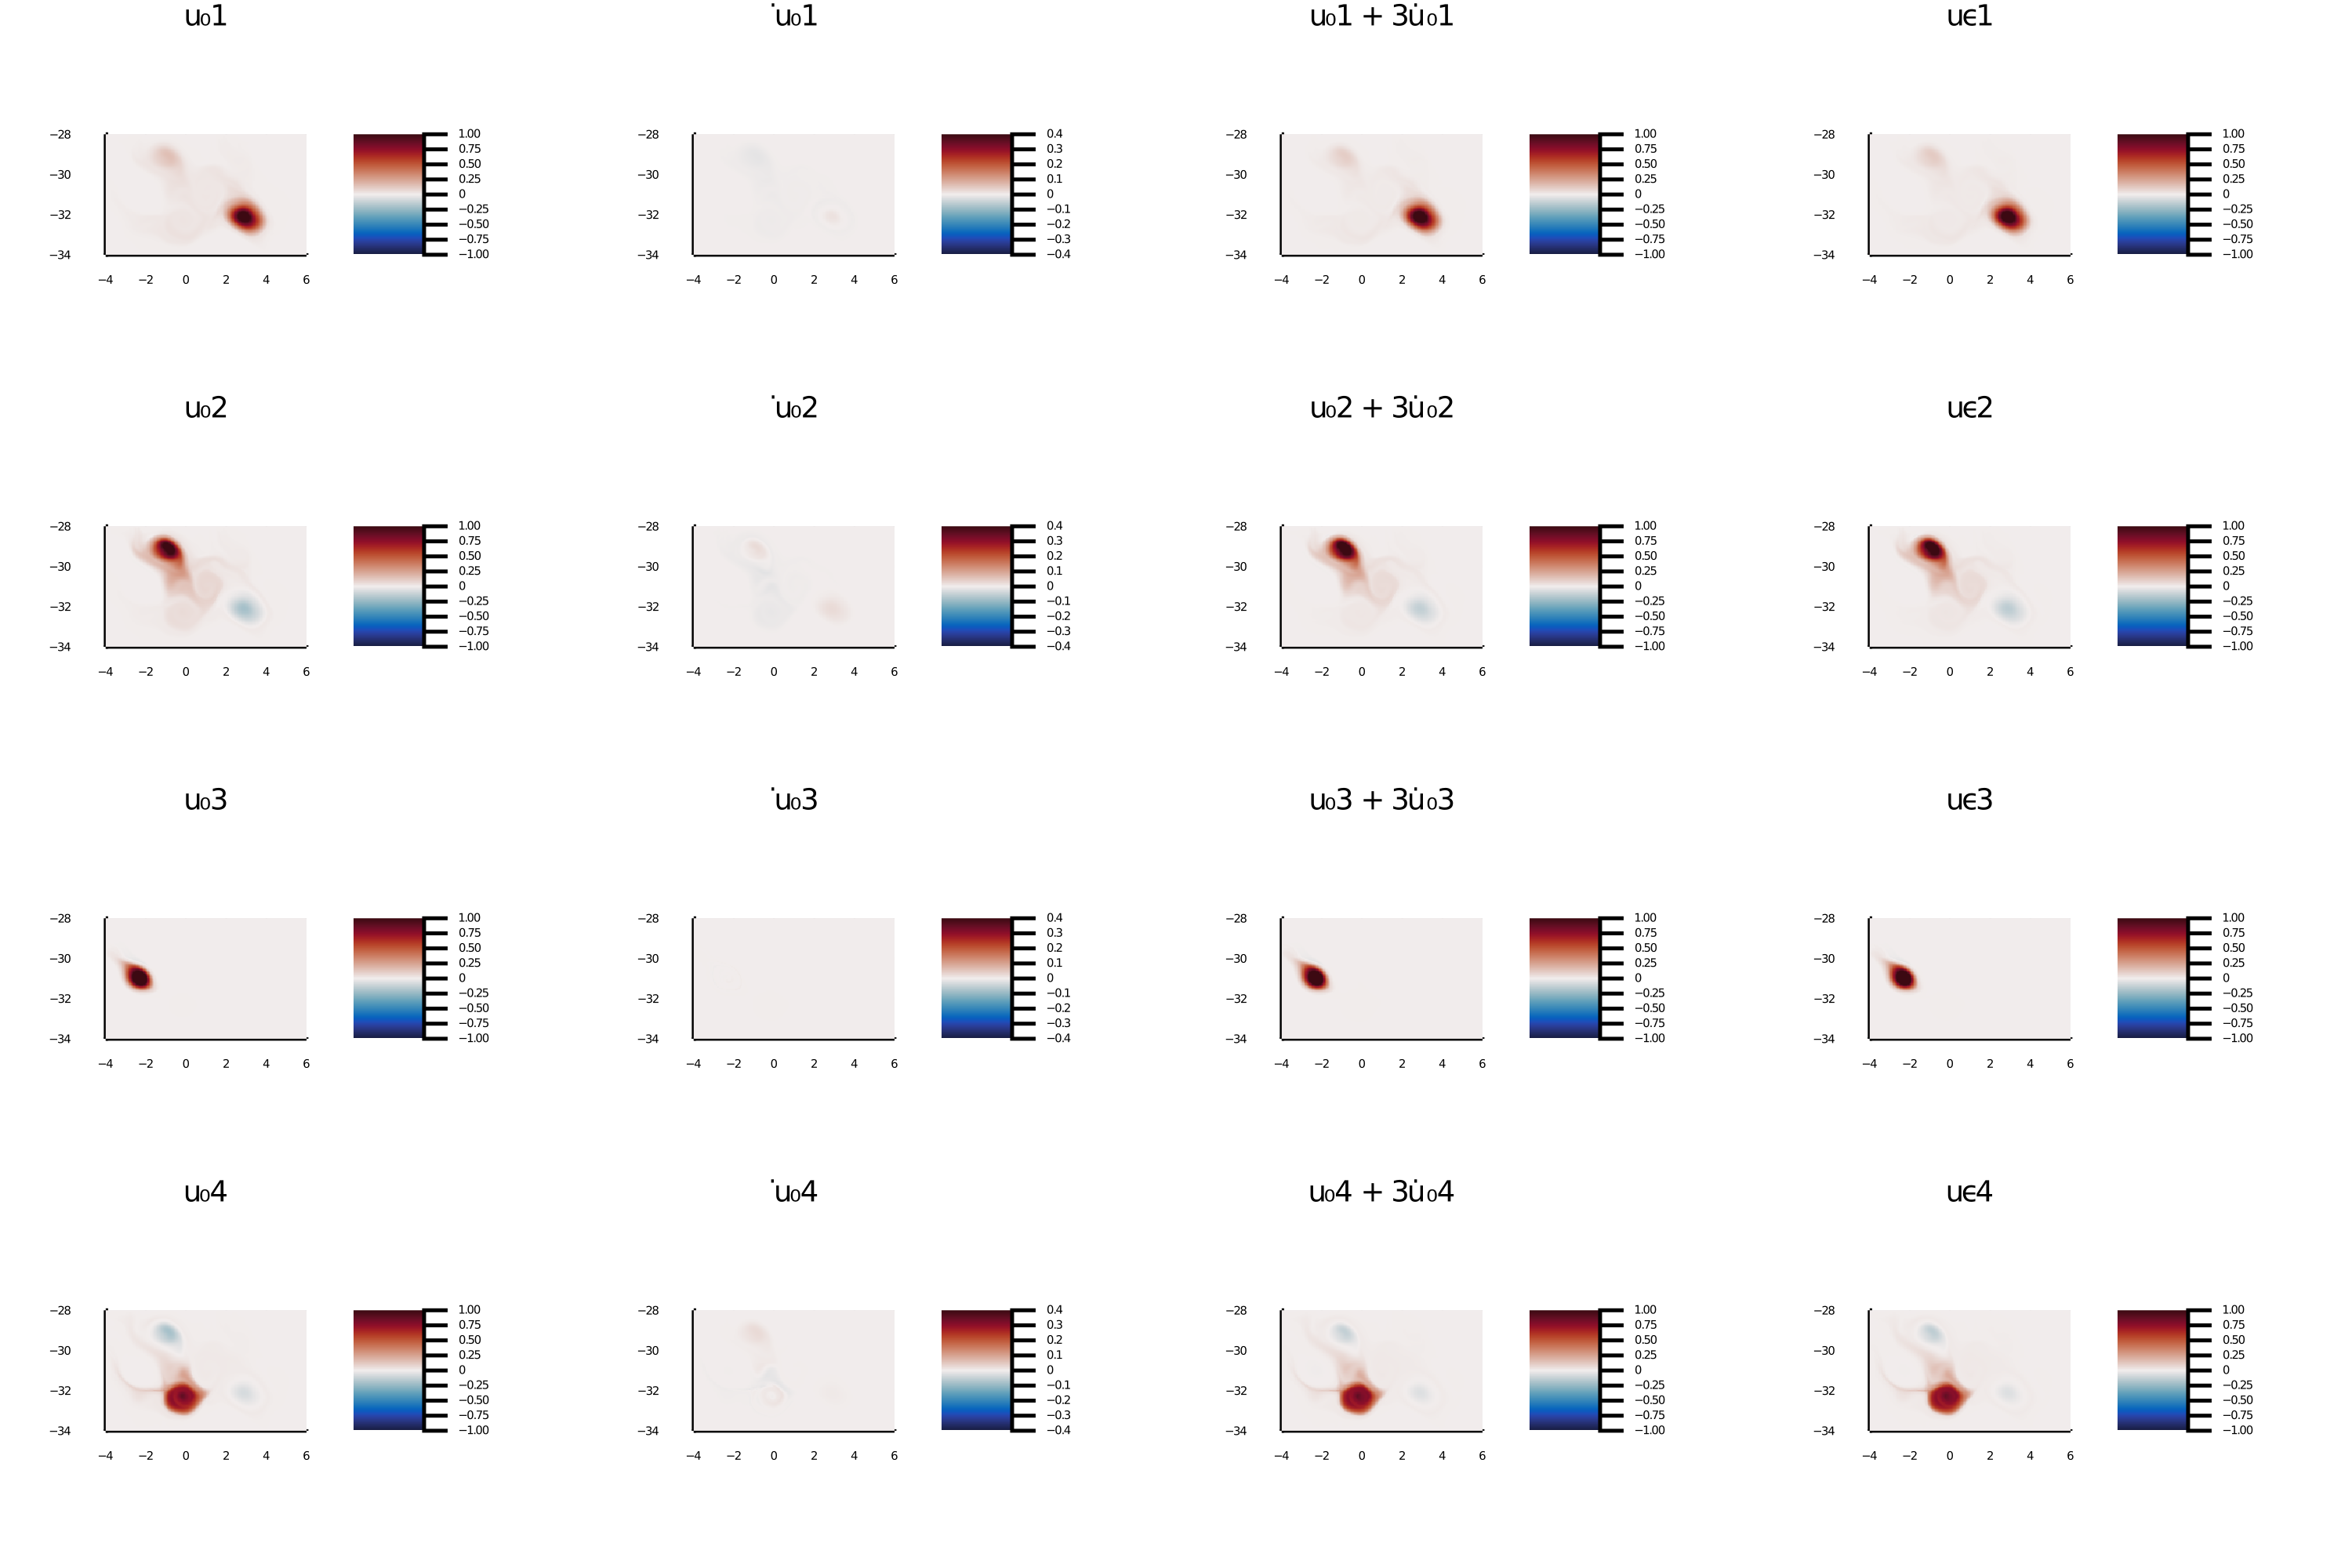

In [50]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i], lon_resolution, lat_resolution, bdata=bdata,
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [22]:
using Contour
using StaticArrays

In [23]:
#Contour.jl needs StaticArrays
T_static(x) = SVector{2,Float64}(T(x,0))

T_static (generic function with 1 method)

In [24]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T_static(x),tolerance=1e-10)
end

dynamic_cheeger_value_levelset (generic function with 1 method)

In [25]:
ev = 2;

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.007723577036567363)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0063537098134831705)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.004983842590398978)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.003613975367314785)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0022441081442305926)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0008742409211463999)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0004956263019377927)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0018654935250219853)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0

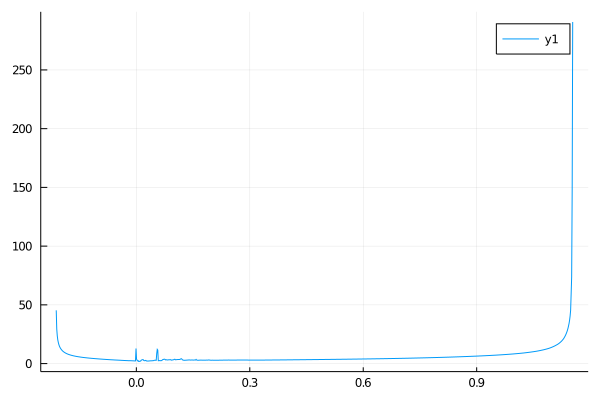

In [26]:
u_max = maximum(u₀[:,ev])
u_min = minimum(u₀[:,ev])
values = []
for c in range(u_min,stop=u_max,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c, bdata=bdata)
    if (length(lines(levelset))>0)
        push!(values,dynamic_cheeger_value_levelset(levelset))
    else 
        push!(values,0)
    end
end
Plots.plot(range(u_min,stop=u_max,length=1000)[2:end-1],values[2:end-1])

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.008134126653875279)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.006766996428239802)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.005399866202604325)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.004032735976968849)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.002665605751333372)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0012984755256978953)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 6.865469993755369e-5)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0014357849255730304)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0028

Dynamic Cheeger value:	1.914973929549622
Levelset:		0.008271436053750414
1.914973929549622	30.10610387842119	70.9224109555701	26.378561419306617


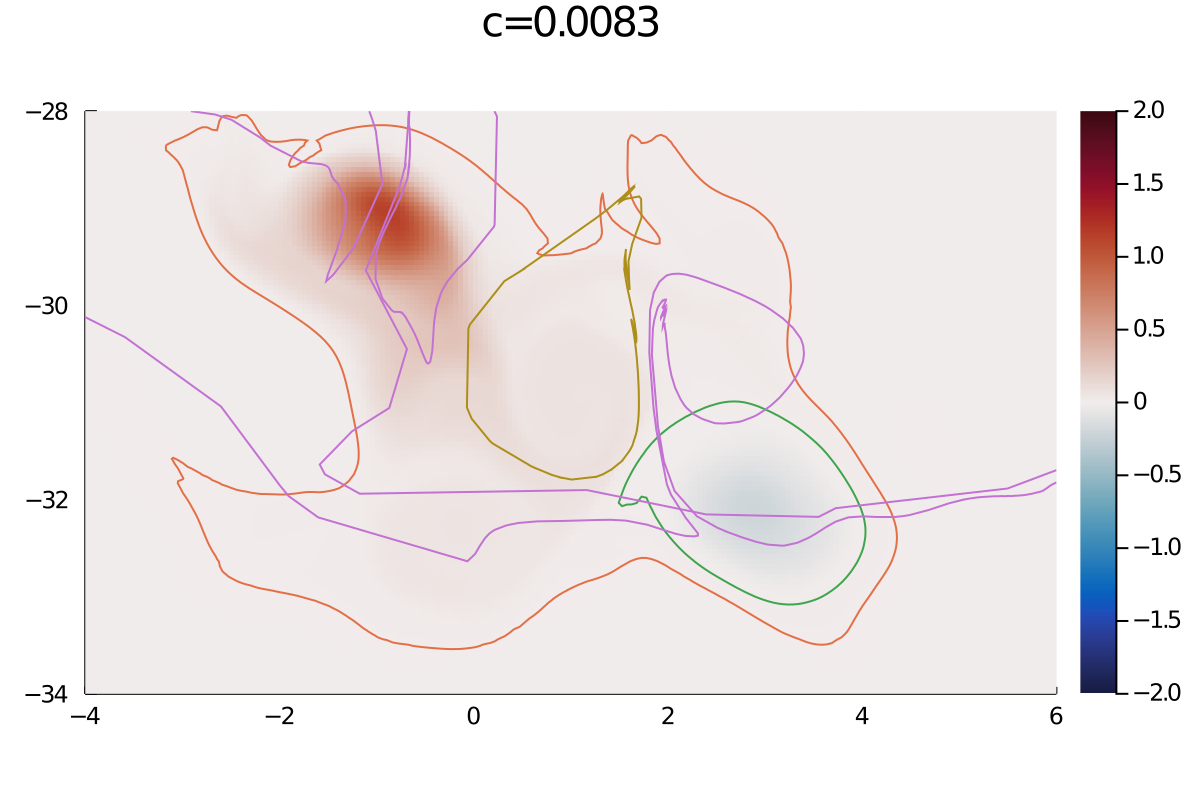

In [27]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀[:,ev],dynamic_cheeger_value_levelset,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")
c_best = level(best_levelset)
plot_u(ctx, u₀[:,ev],  lon_resolution, lat_resolution, title="c=$(round(c_best,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀[:,ev], c_best, bdata=bdata))
curves_moved = [Main.CoherentStructures.apply2curve(T_static,c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], T_static)
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(-4,6), ylims=(-34,-28))

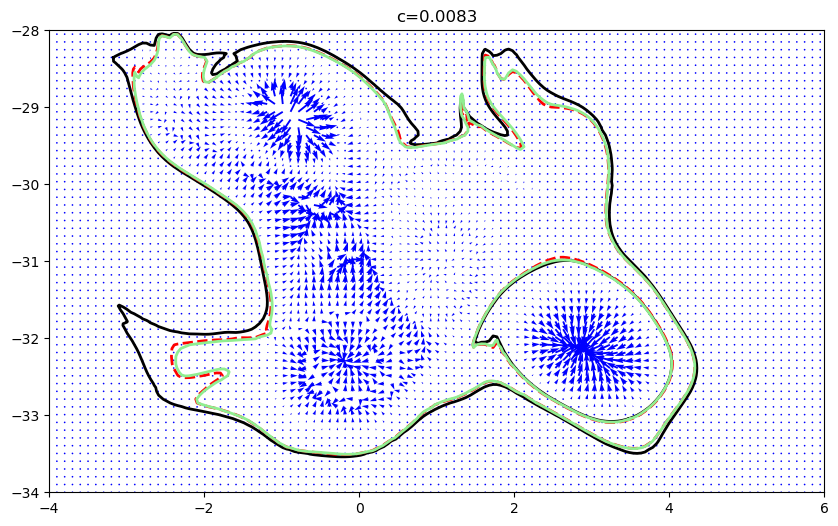

In [28]:
using PyCall
using PyPlot
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
plot_vectorfield(get_levelset_evolution(ctx,u₀[:,ev],u_dot[:,ev], bdata=bdata)...,ax,scale=1,step=2)
curves           = lines(get_levelset(ctx, u₀[:,ev], c_best, bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, uϵ[:,ev], c_best, bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀[:,ev] + ϵ*u_dot[:,ev], c_best, bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

## SEBA

In [29]:
μ = 0.99/sqrt(lon_resolution*lat_resolution);

In [30]:
@time S, R = SEBA(u₀,μ=μ,returnR=true,sort=false);

  1.530165 seconds (6.32 M allocations: 343.908 MiB, 4.41% gc time)


In [31]:
inv(qr(u₀).R)*R'

4×4 Array{Float64,2}:
  0.0496147    0.00760298   7.54224e-6   0.00308844
 -0.00789639   0.0493608   -5.76652e-6   0.00541991
  3.63153e-6  -1.69495e-5  -0.050252     0.000107139
 -0.00220619  -0.00581829   0.000107171  0.0498874

In [32]:
order = sortperm([-minimum(S[:,i]) for i in 1:nev]);

In [33]:
Sprime = Matrix(qr(u₀).Q)*R';

In [34]:
Sdot = u_dot*inv(qr(u₀).R)*R';

In [53]:
Sϵ, Rϵ = SEBA(uϵ,μ=μ,returnR=true,sort=false);

In [54]:
Sϵprime = Matrix(qr(uϵ).Q)*Rϵ';

##### Compare different ways to arrive at a similar result

In [59]:
cmins = [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
cmaxs = -1 .* cmins
cmins_lr = [-.1, -.1, -.1, -.1, -.1, -.1, -.1, -.1, -.1]
cmaxs_lr = -1 .* cmins_lr;

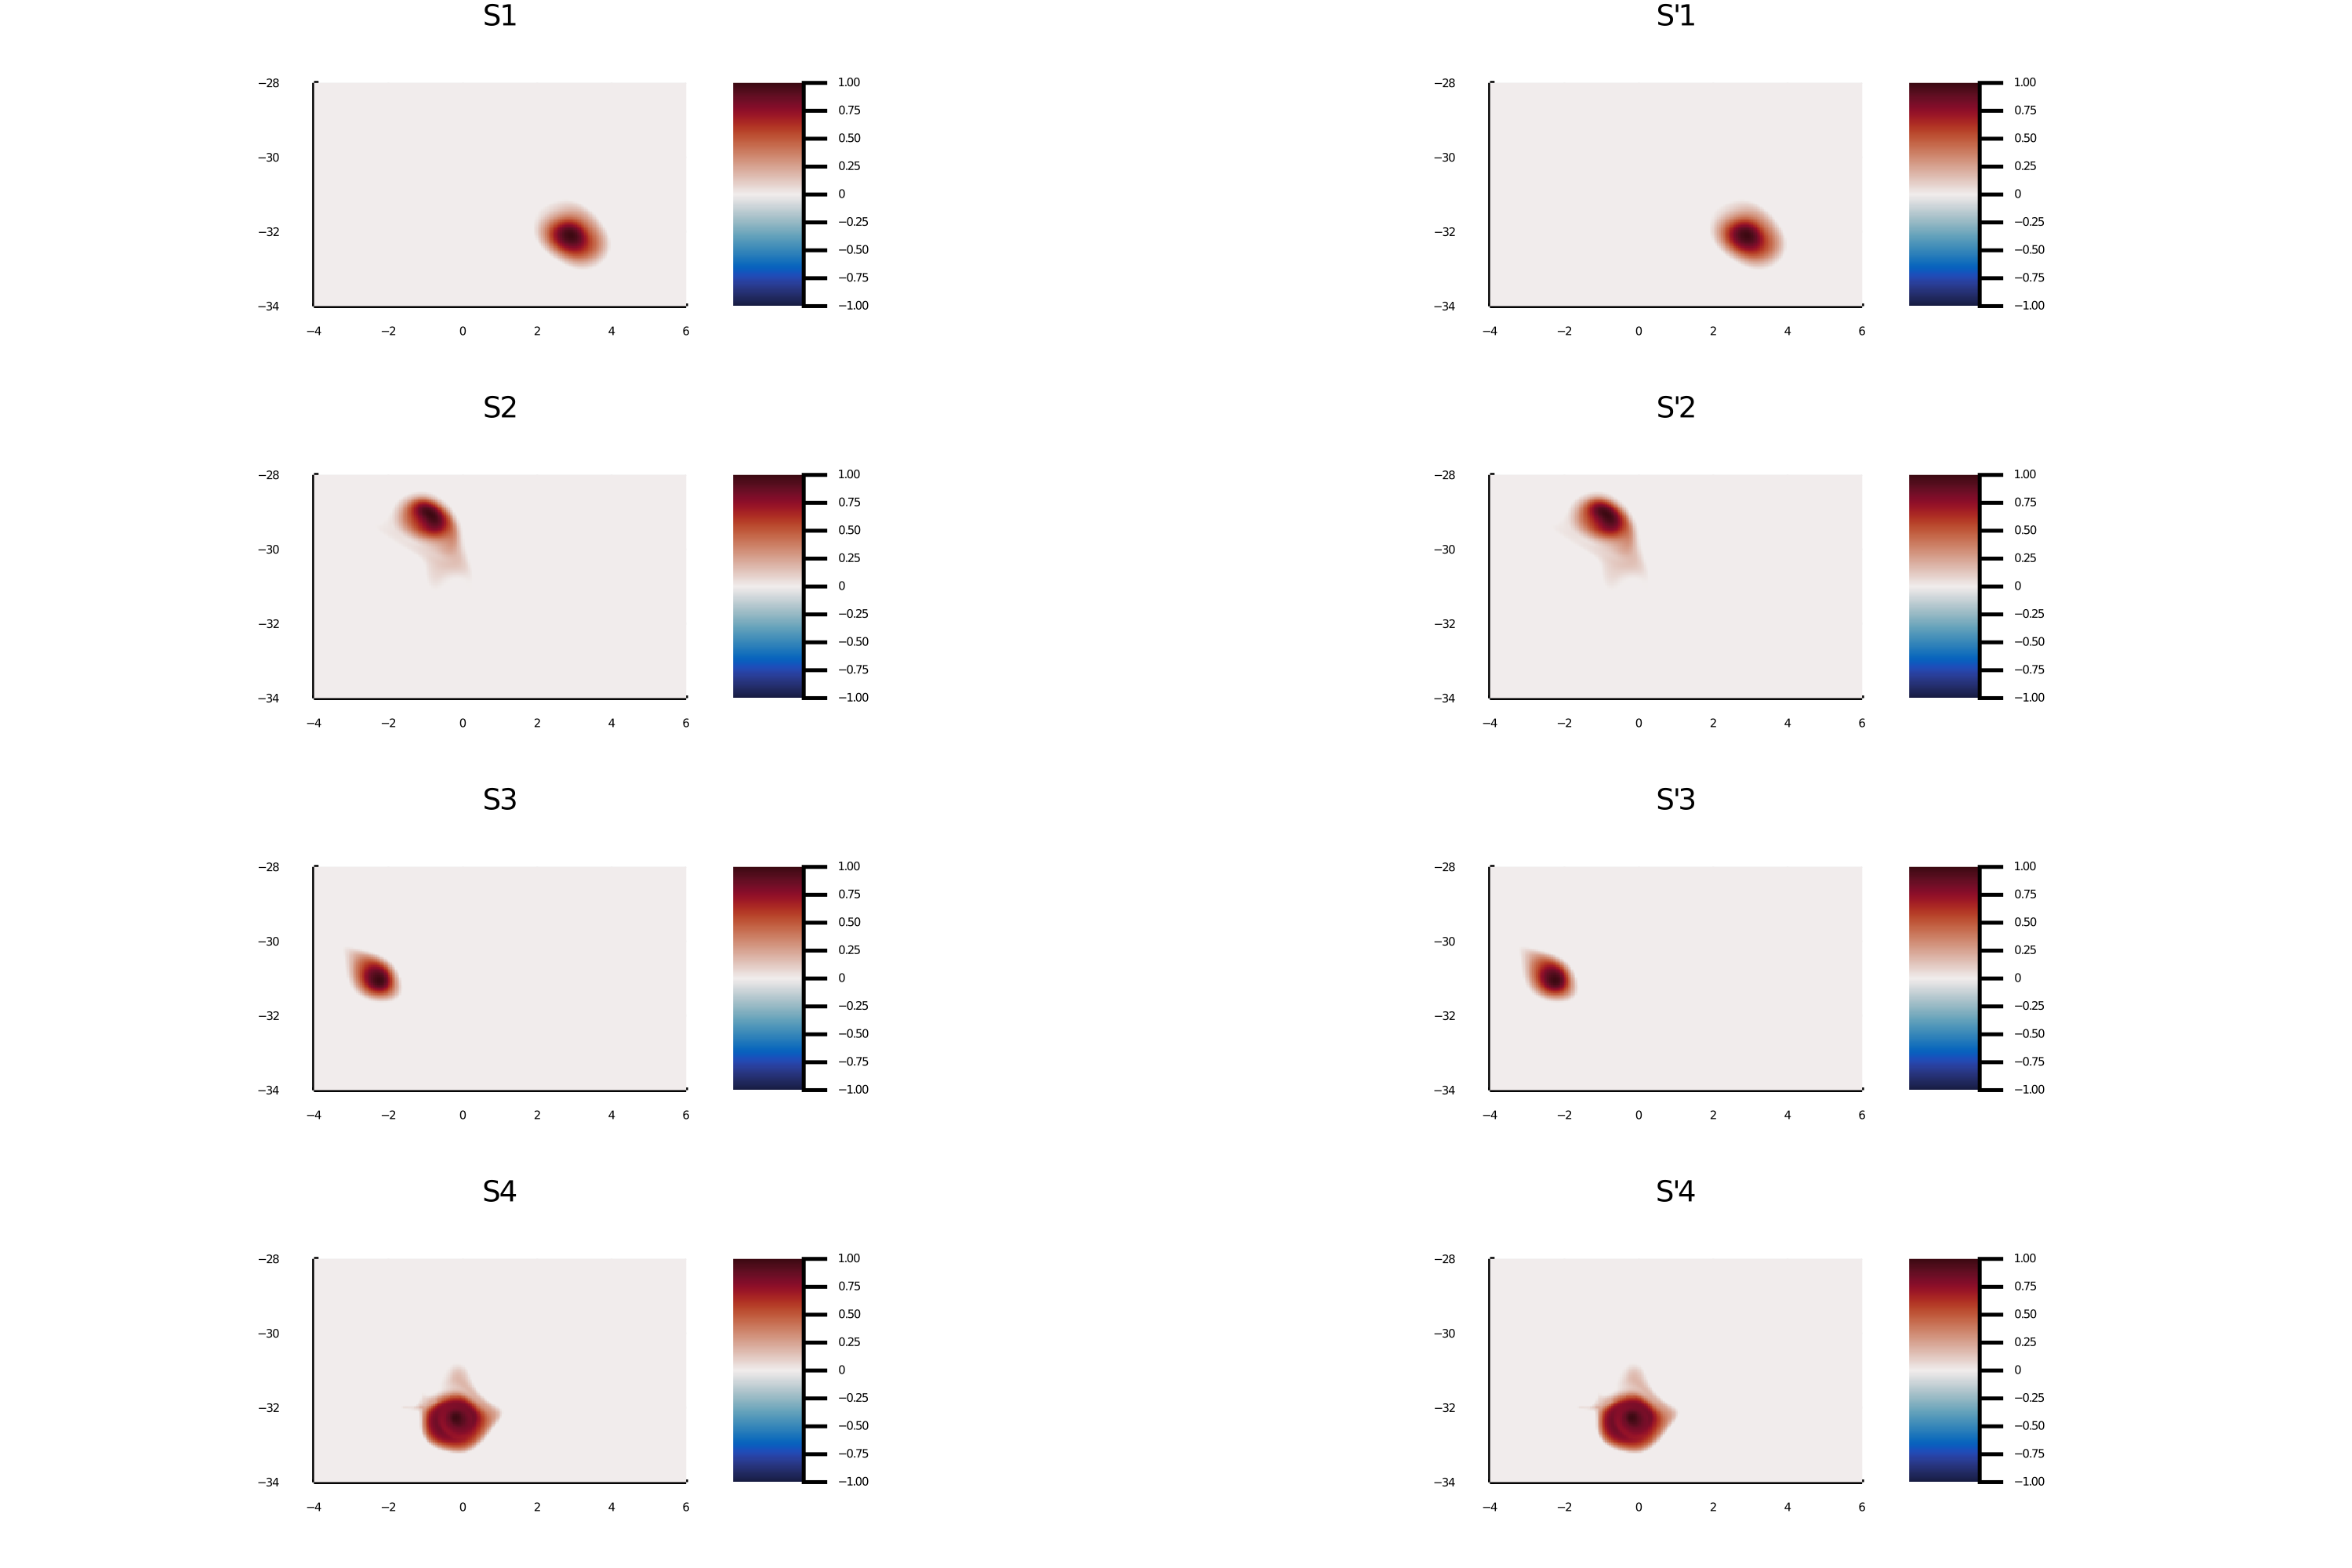

In [56]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="S"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(Sprime[:,i],μ)), grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

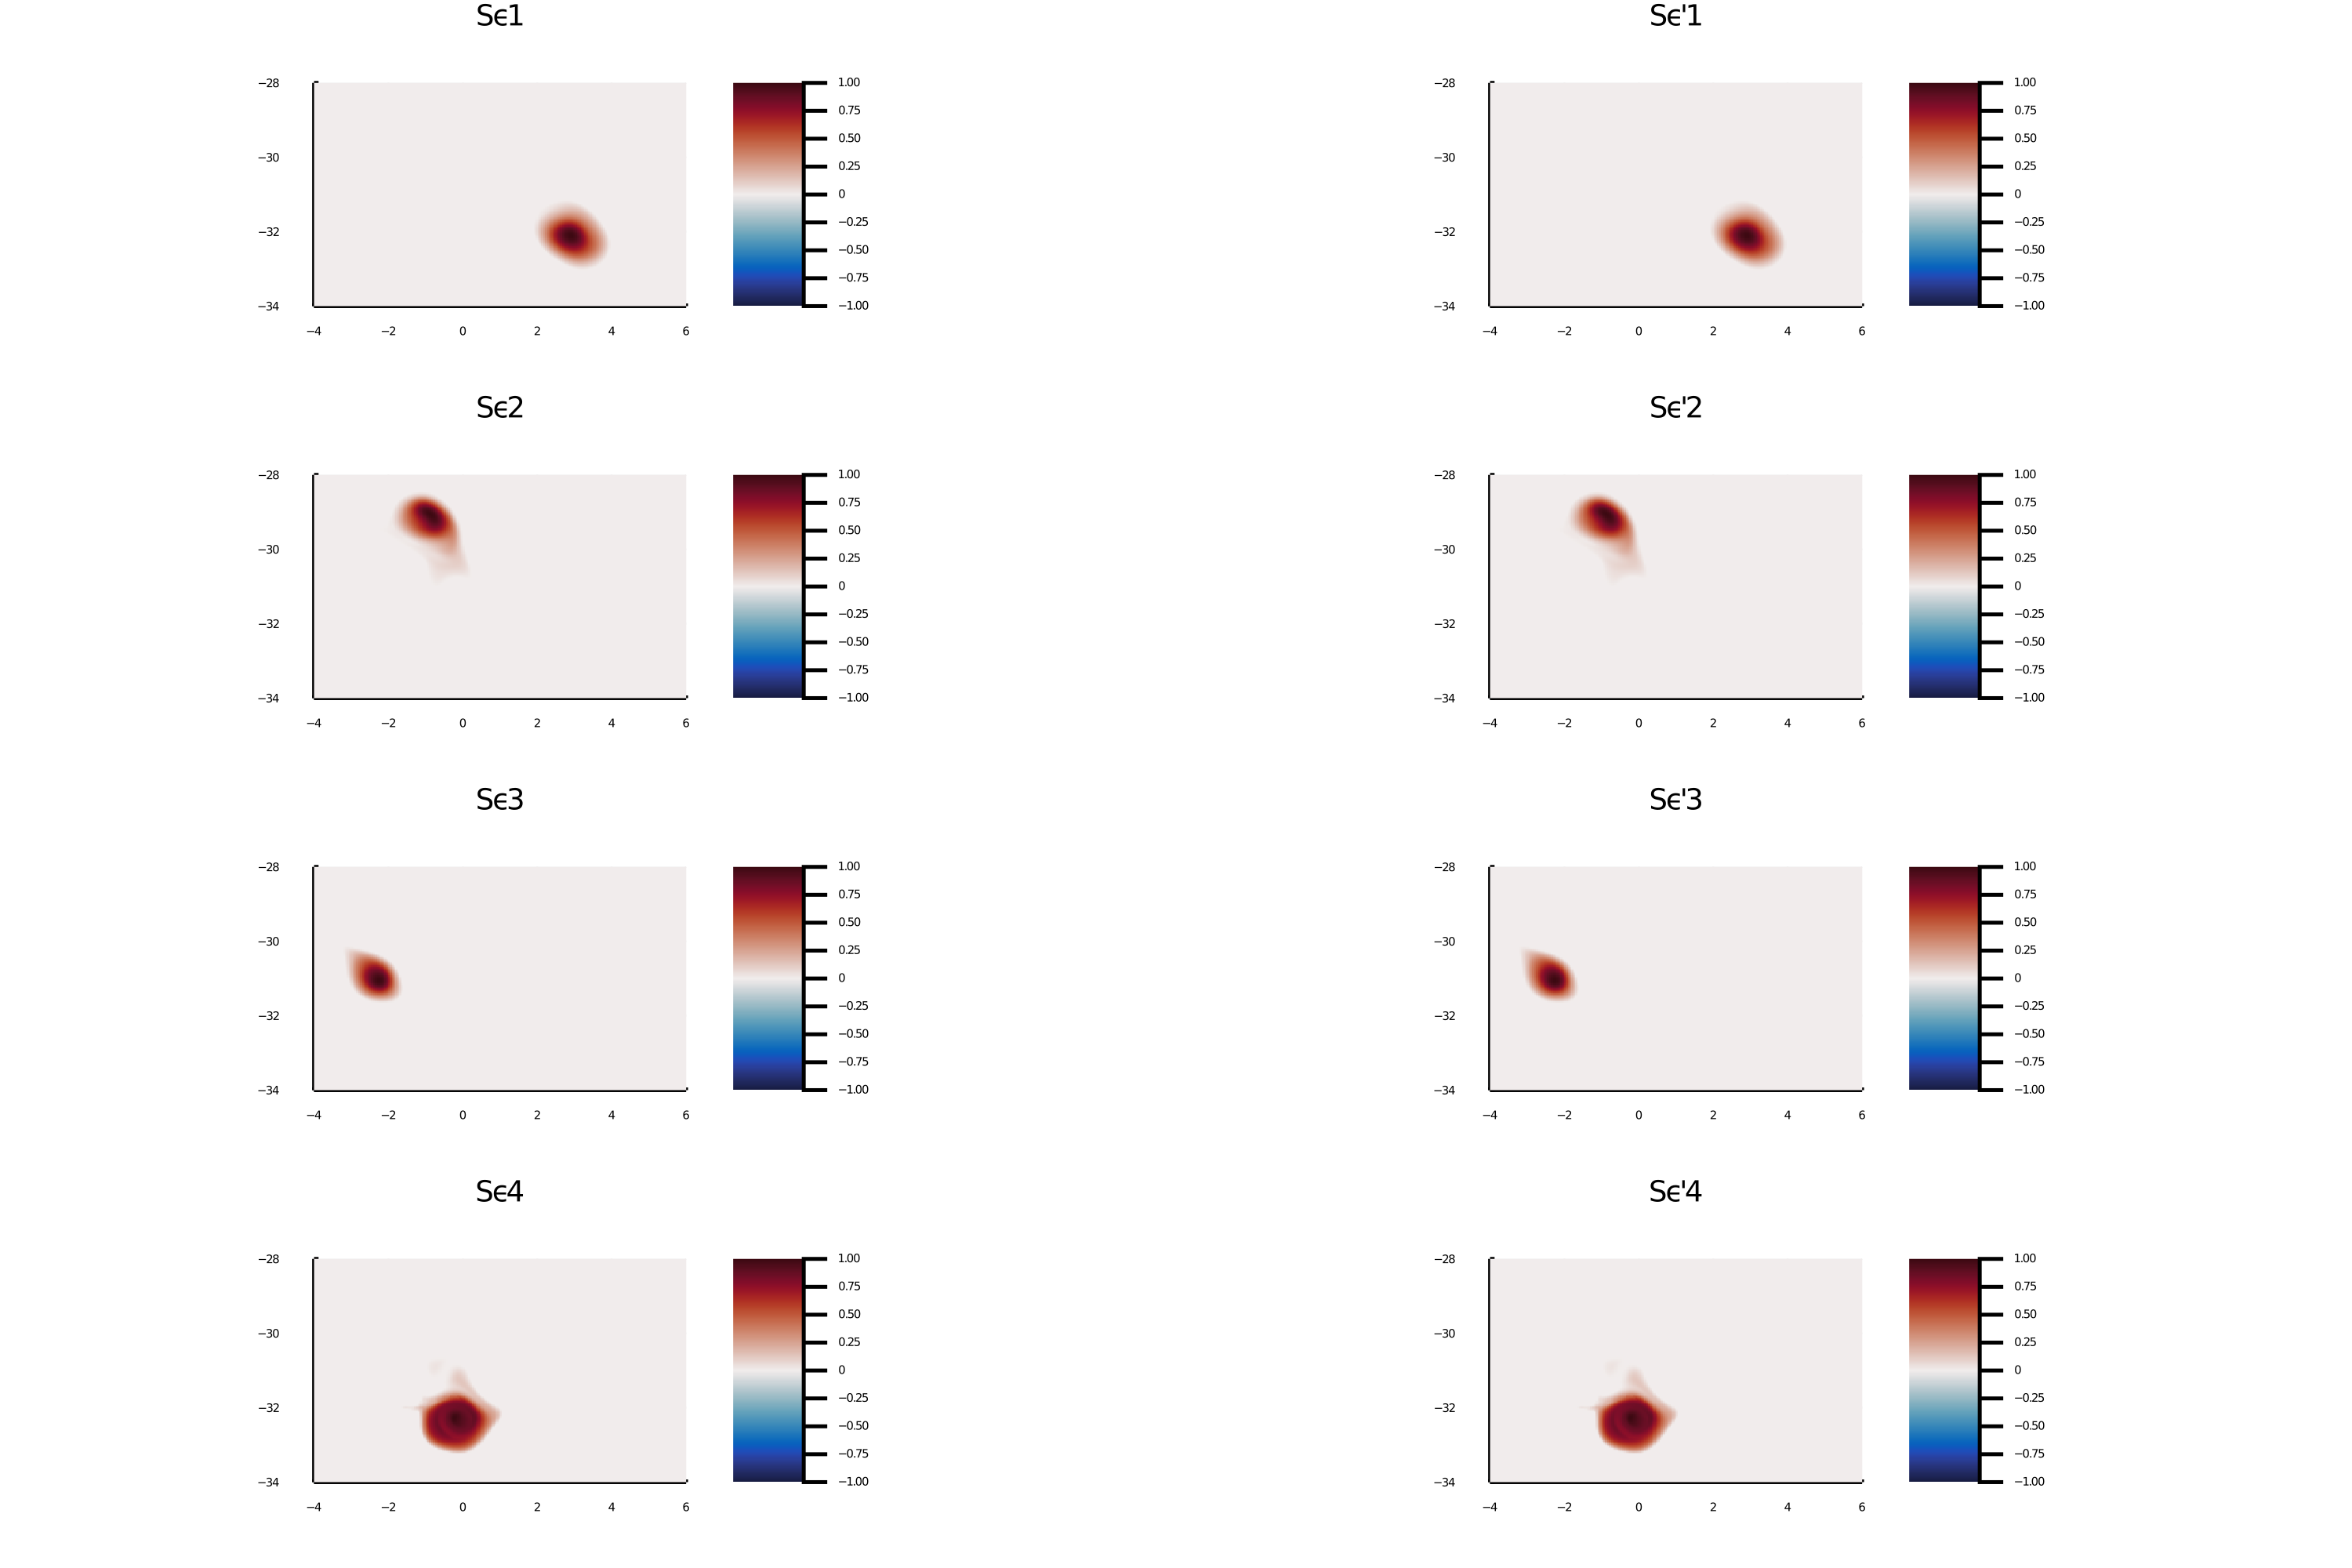

In [57]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, Sϵ[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(Sϵprime[:,i],μ)), grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ'"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

### Prediction

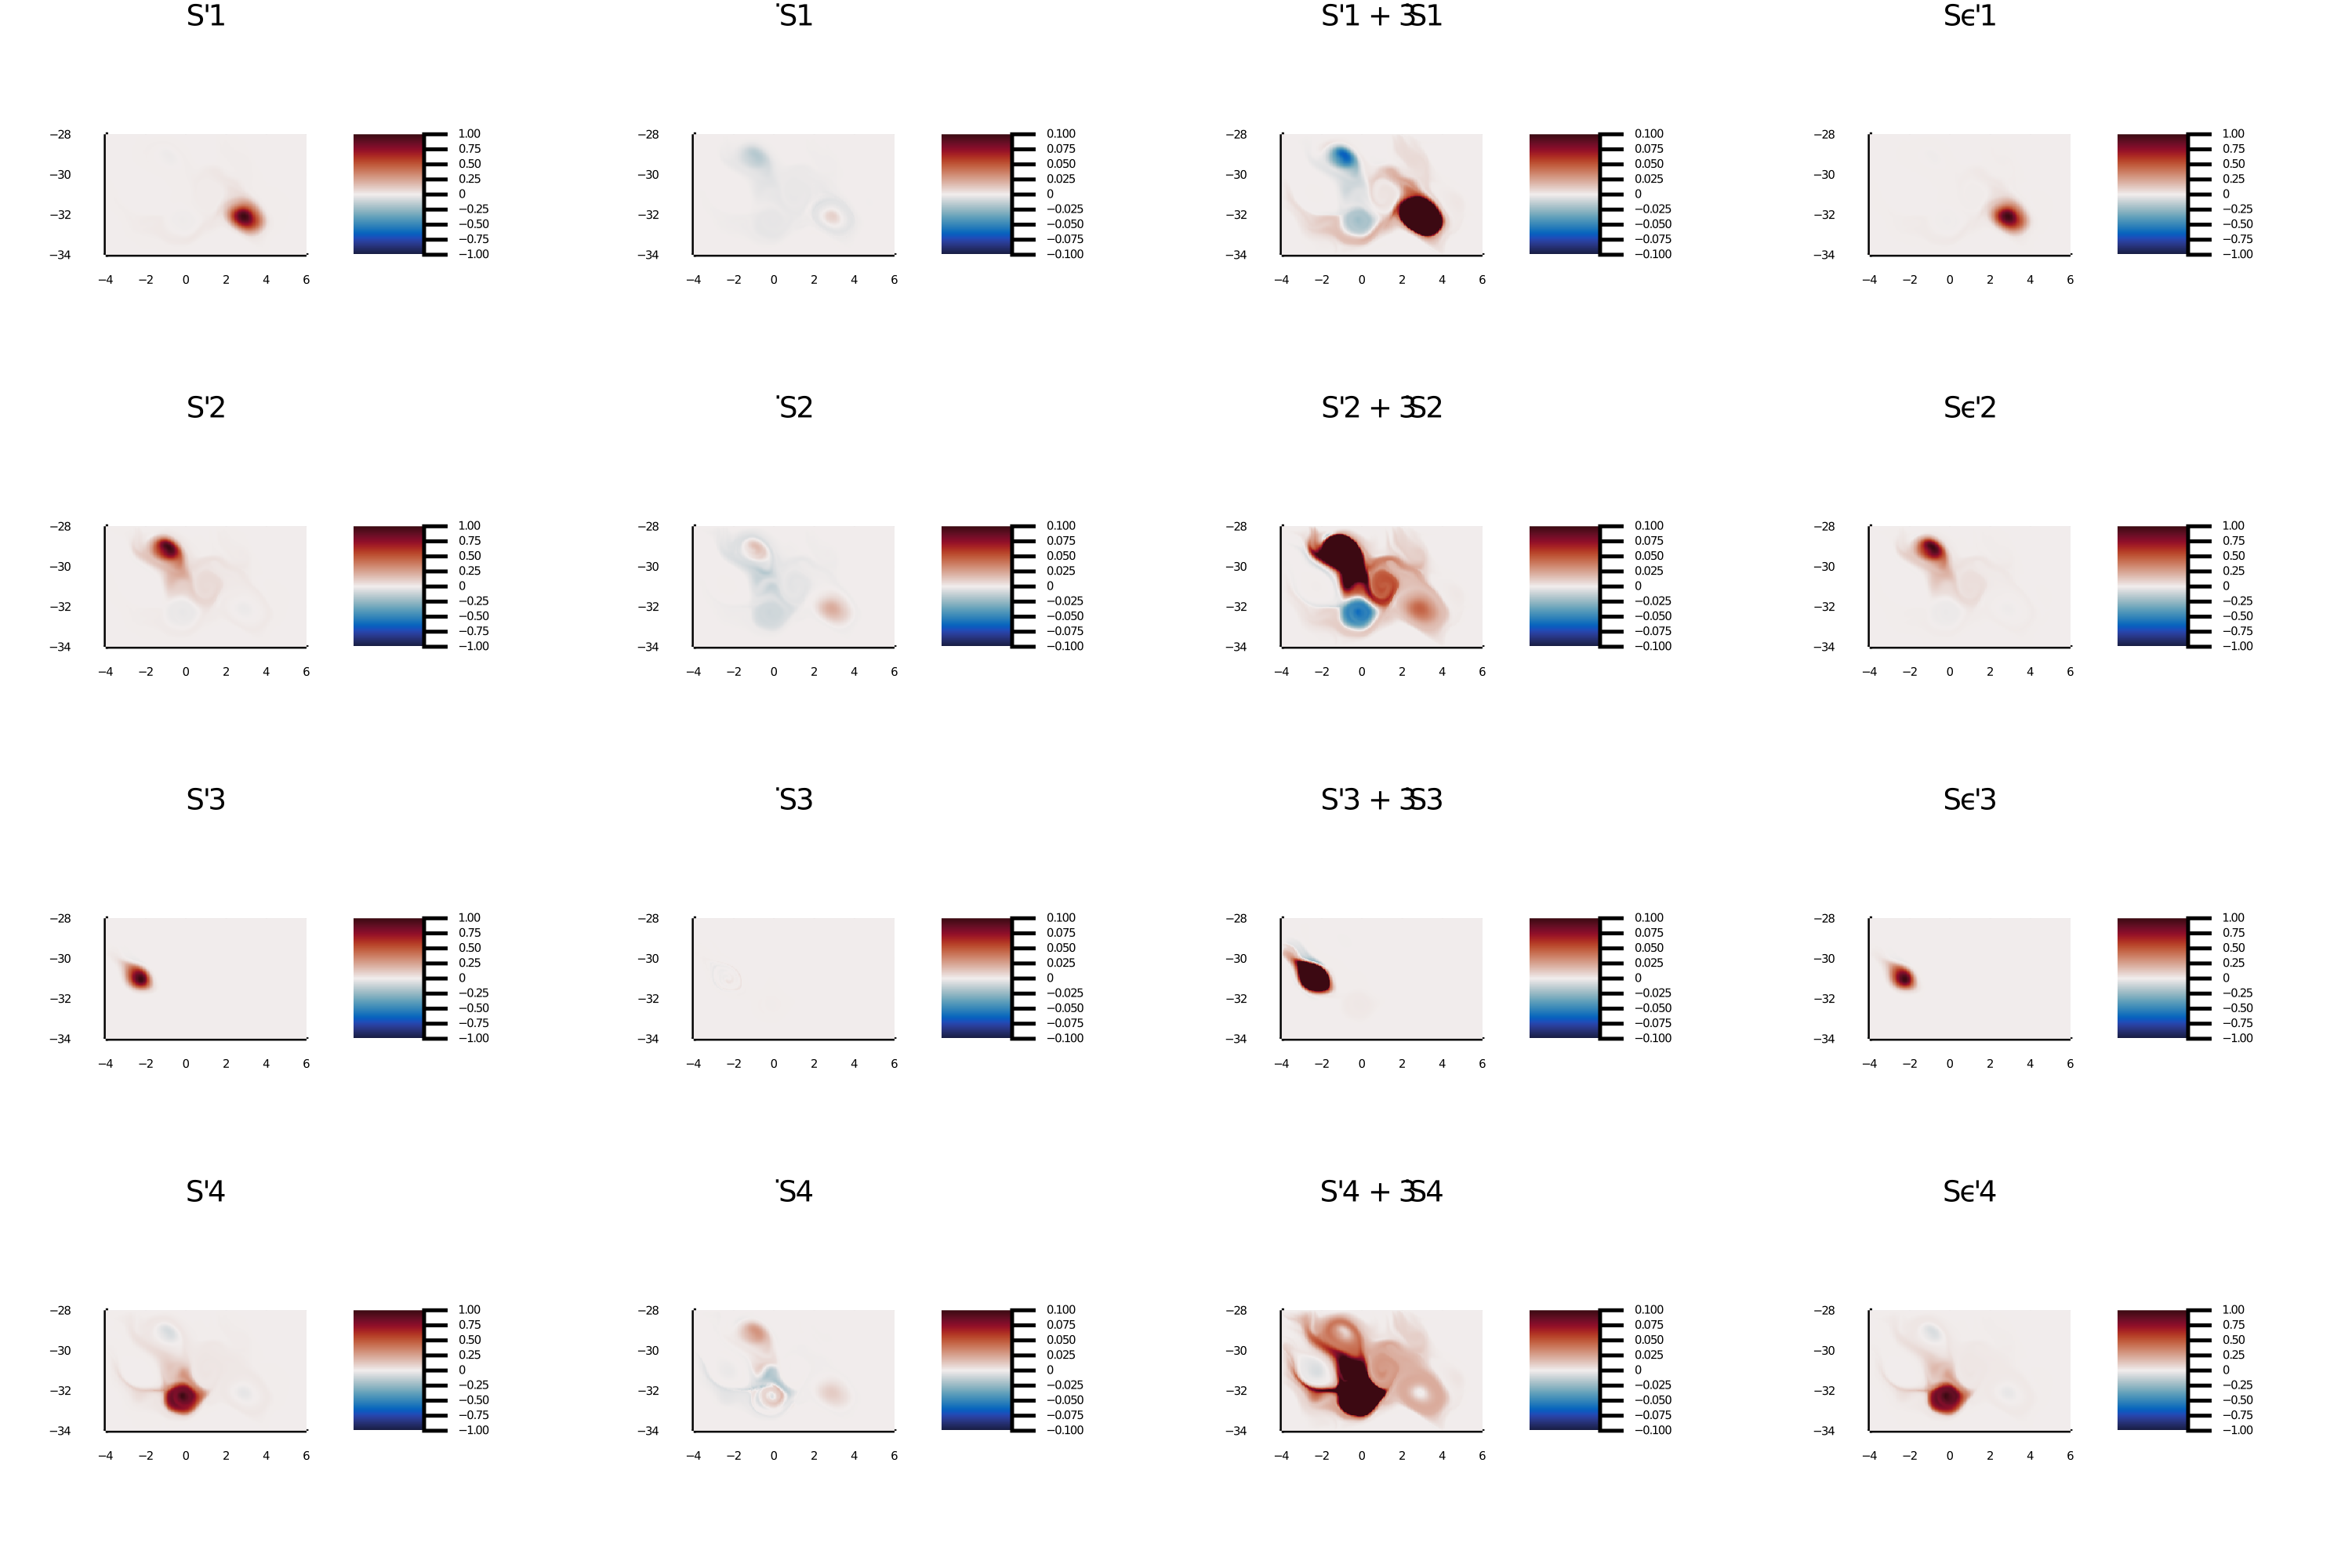

In [60]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, normalizeU(Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sdot[:,i],Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="̇S"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sprime[:,i] + ϵ*Sdot[:,i],Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i)*" + $(ϵ)̇S"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sϵprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ'"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

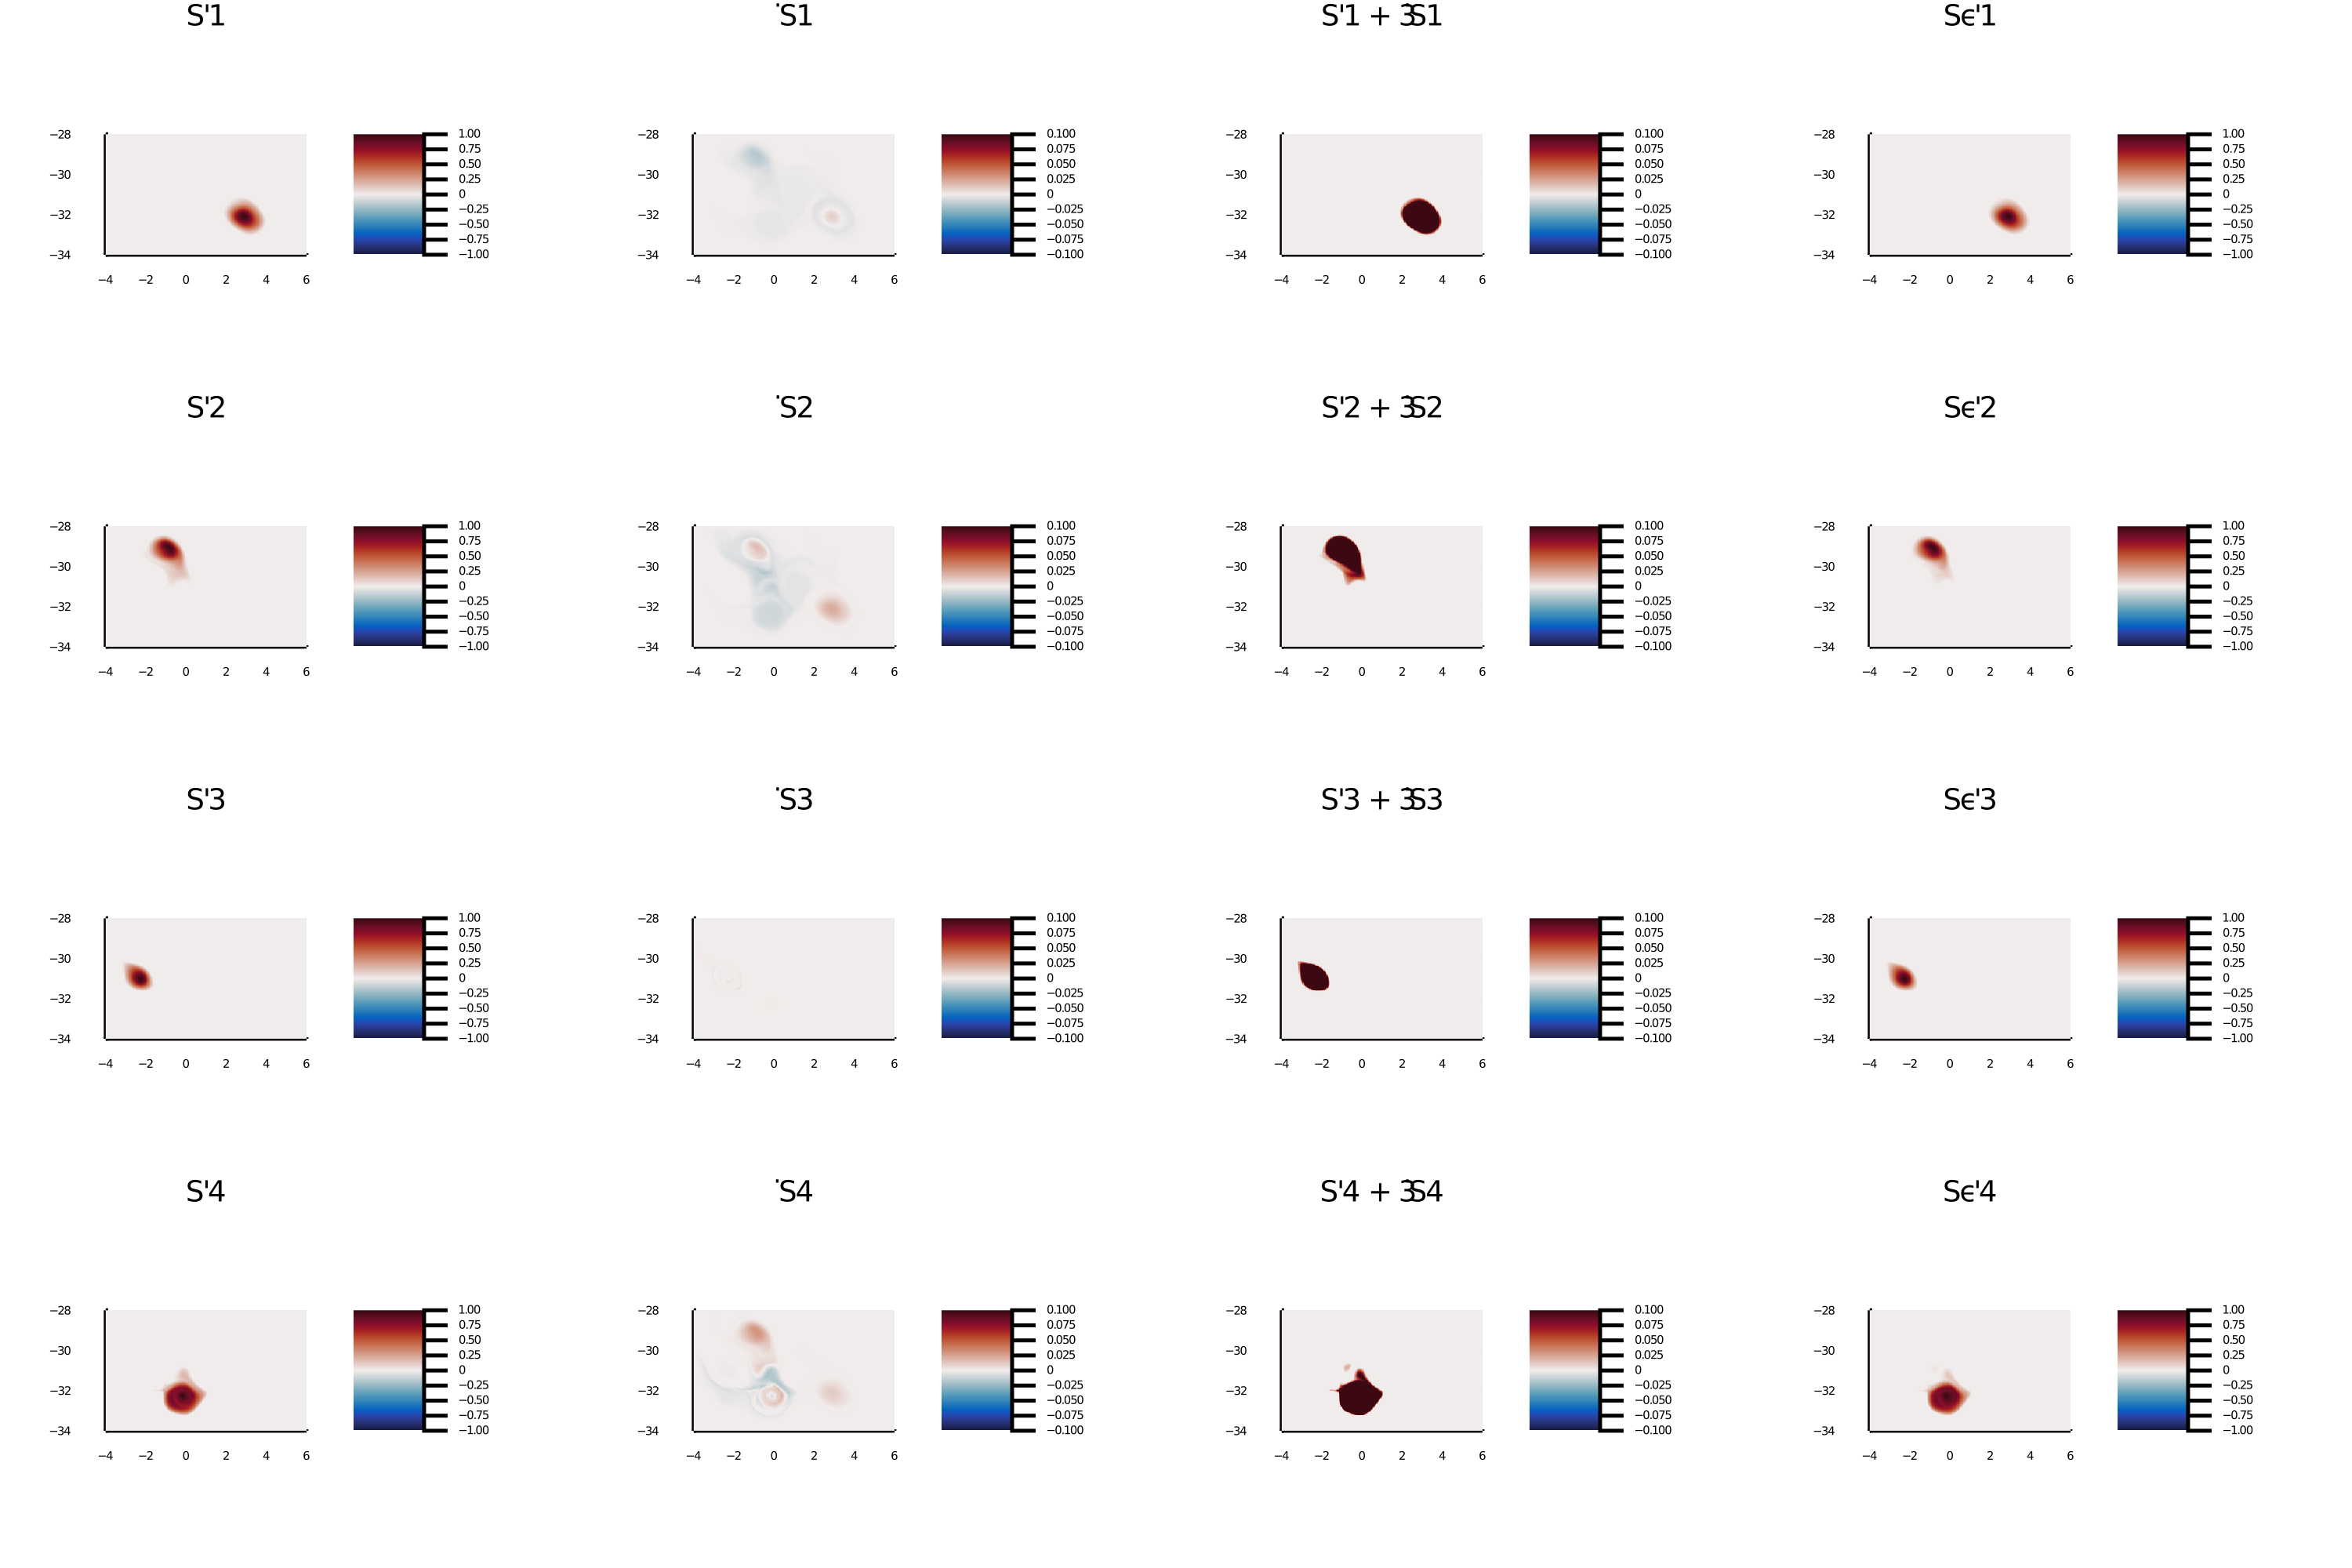

In [86]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sdot[:,i],Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="̇S"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(Sprime[:,i] + ϵ*Sdot[:,i],μ),Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i)*" + $(ϵ)̇S"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ'"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [78]:
ev = 4;

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04804804804804805)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04904904904904905)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.05005005005005005)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.05105105105105105)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.05205205205205205)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18018018018018017)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18118118118118118)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18218218218218218)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1831831831831832)
└ 

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8368368368368369)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8378378378378378)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8388388388388388)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8398398398398398)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8408408408408409)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8418418418418419)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8428428428428428)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8438438438438438)
└ @ Main In[24]:4


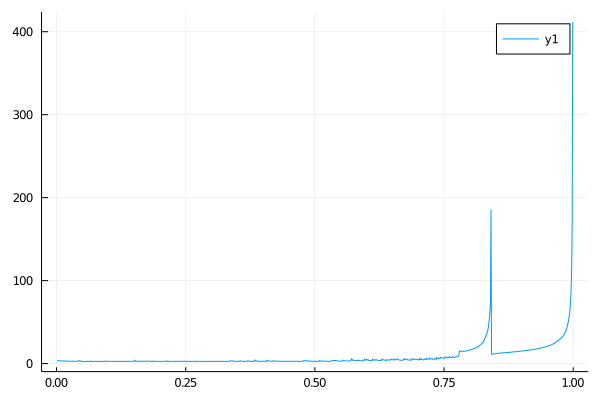

In [79]:
u_max = maximum(S[:,ev])
u_min = minimum(S[:,ev])
values = []
for c in range(u_min,stop=u_max,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,S[:,ev],c, bdata=bdata)
    if (length(lines(levelset))>0)
        push!(values,dynamic_cheeger_value_levelset(levelset))
    else 
        push!(values,0)
    end
end
Plots.plot(range(u_min,stop=u_max,length=1000)[2:end-1],values[2:end-1])

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.047952047952047945)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04895104895104894)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04995004995004994)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.05094905094905094)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.05194805194805194)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.05294705294705294)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17982017982017978)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18081918081918077)
└ @ Main In[24]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18181818181818177)


Dynamic Cheeger value:	2.583954402526648
Levelset:		0.08791208791208789
2.583954402526648	7.0283917970998715	8.704729340748196	3.0443883070196347


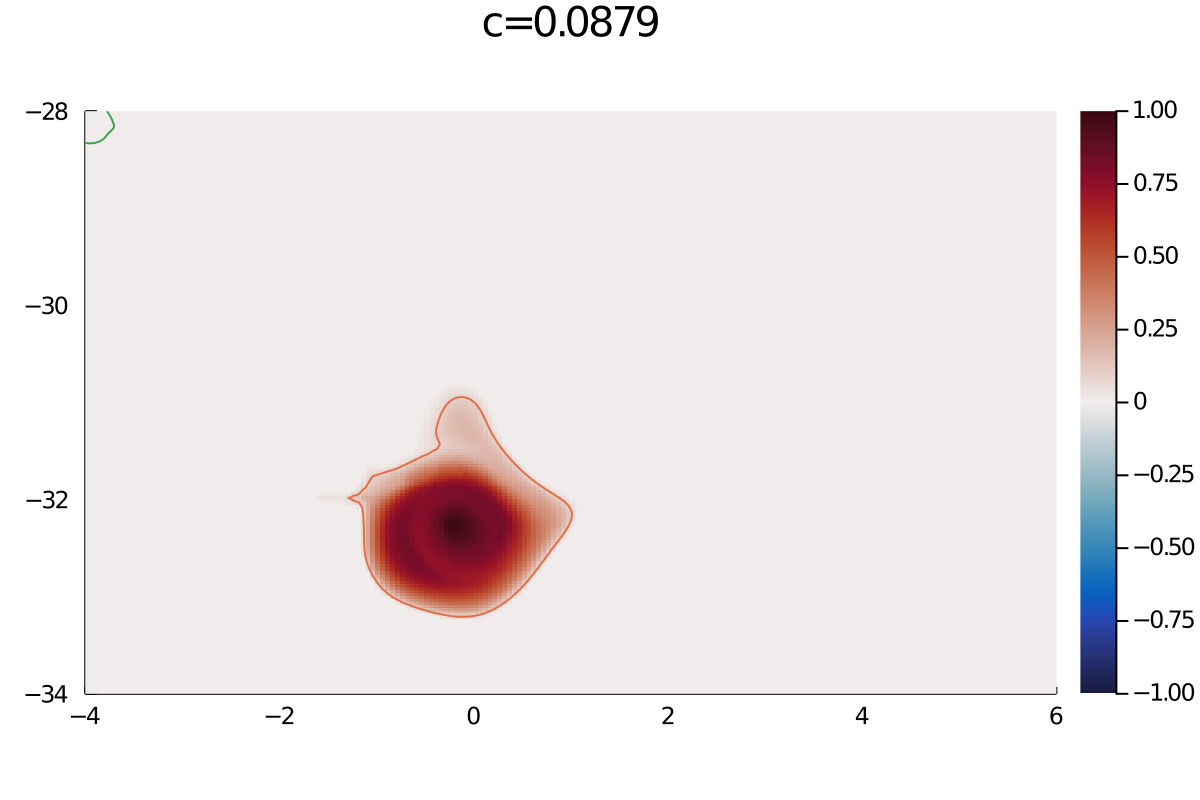

In [90]:
best_levelset, best_value = get_minimal_levelset(
    ctx,S[:,ev],dynamic_cheeger_value_levelset,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")
c_best = level(best_levelset)
plot_u(ctx, S[:,ev],  grid_resolution, grid_resolution, title="c=$(round(c_best,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, S[:,ev], c_best, bdata=bdata))
curves_moved = [Main.CoherentStructures.apply2curve(T_static,c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], T_static)
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(-4,6), ylims=(-34,-28))

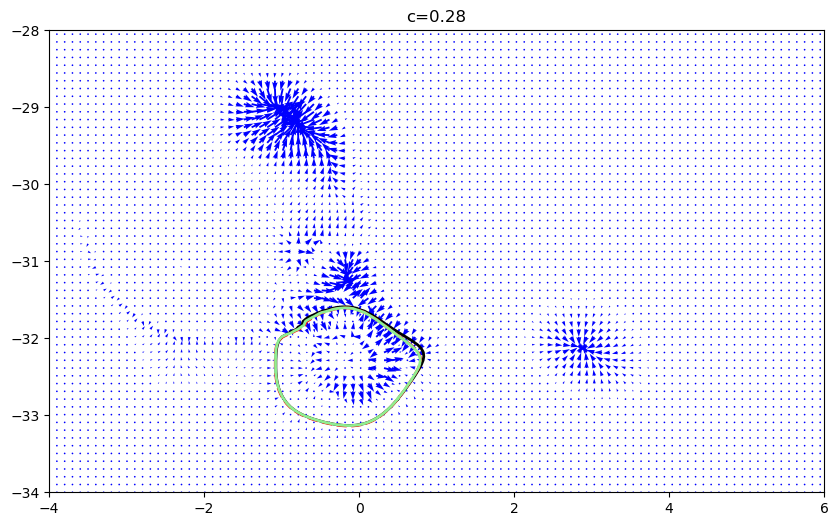

In [97]:
using PyCall
using PyPlot

c_best = 0.28

plt.figure(figsize=(7,7), dpi=100)
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
plot_vectorfield(
                get_levelset_evolution(ctx,normalizeU(Sprime[:,ev]),normalizeU(Sdot[:,ev],Sprime[:,ev]),bdata=bdata)...,
                ax,scale=1,step=2)
curves           = lines(get_levelset(ctx, S[:,ev], c_best, bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, Sϵ[:,ev], c_best, bdata=bdata))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(Sprime[:,ev] + ϵ*Sdot[:,ev],μ)), c_best, bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");